In [1]:
# get VGGNET16 from pytorch
import torch
import torchvision
from torchsummary import summary

model = torchvision.models.vgg16(pretrained=True)
# Assuming your model is named 'model'
# summary(model, (3, 224, 224))
print(model)
for name, layer in model.features.named_children():
    print(f"Layer name: {name}, Layer type: {type(layer).__name__}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sakshaymahna_kittiroadsegmentation_path = kagglehub.dataset_download('sakshaymahna/kittiroadsegmentation')

print('Data source import complete.')

100%|██████████| 305M/305M [00:15<00:00, 20.5MB/s]

Extracting files...


Data source import complete.


In [3]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

# Load directories
train_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/training/image_2/"
train_gt_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/training/gt_image_2/"

test_data_dir = "/root/.cache/kagglehub/datasets/sakshaymahna/kittiroadsegmentation/versions/1/testing/"

# Number of training examples
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, data_dir, train=True, val_split=0.2, test_split=0.1, seed=42):
        self.data_dir = data_dir
        self.train = train

        # Get all image paths
        image_paths = [os.path.join(data_dir, img_name) for img_name in os.listdir(data_dir) if img_name.endswith(".png")]

        # Shuffle image paths using the seed for reproducibility
        random.seed(seed)
        random.shuffle(image_paths)

        # Calculate split indices
        total_len = len(image_paths)
        train_len = int(total_len * (1 - val_split - test_split))
        val_len = int(total_len * val_split)

        # Split paths based on train/val/test
        if self.train:
            self.image_paths = image_paths[:train_len]
        elif val_split > 0: # If val_split is 0, use remaining as test
            self.image_paths = image_paths[train_len:train_len + val_len]
        else:
            self.image_paths = image_paths[train_len + val_len:]

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        self.road_label = np.array([255, 0, 255])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get mask path and load mask
        mask_path = img_path.replace("image_2", "gt_image_2")
        mask_path = mask_path.replace("um_", "um_road_")
        mask_path = mask_path.replace("umm_", "umm_road_")
        mask_path = mask_path.replace("uu_", "uu_road_")
        mask = Image.open(mask_path).convert('RGB')

        # Convert mask to binary
        mask_np = np.array(mask)
        mask_binary = np.all(mask_np == self.road_label, axis=2)
        mask = Image.fromarray(mask_binary.astype(np.uint8))

        # Apply transforms
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Resize
        resize_transform = transforms.Resize((IMG_SIZE, IMG_SIZE))
        image = resize_transform(image)
        mask = resize_transform(mask)

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min())
        # image = image.type(torch.float32) / 255.0
        mask = torch.where(mask > 0, torch.tensor(1.0), torch.tensor(0.0))


        # Data augmentation (only for training)
        # if self.train:
        #     if random.random() > 0.5:
        #         image = transforms.functional.hflip(image)
        #         mask = transforms.functional.hflip(mask)

        return image, mask

# Example usage
# train_data_dir = "/path/to/your/train/data"  # Replace with your train data directory
# val_data_dir = "/path/to/your/val/data"  # Replace with your validation data directory
# test_data_dir = "/path/to/your/test/data"  # Replace with your test data directory

train_dataset = SegmentationDataset(train_data_dir, train=True)
val_dataset = SegmentationDataset(train_data_dir, train=False, val_split=0.2)
test_dataset = SegmentationDataset(train_data_dir, train=False, val_split=0, test_split=0.1)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
train_dataset[0][0].shape, train_dataset[0][1].shape, train_dataset[0][1].dtype

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]), torch.float32)

torch.Size([3, 128, 128]) torch.Size([1, 128, 128]) <class 'torch.Tensor'>


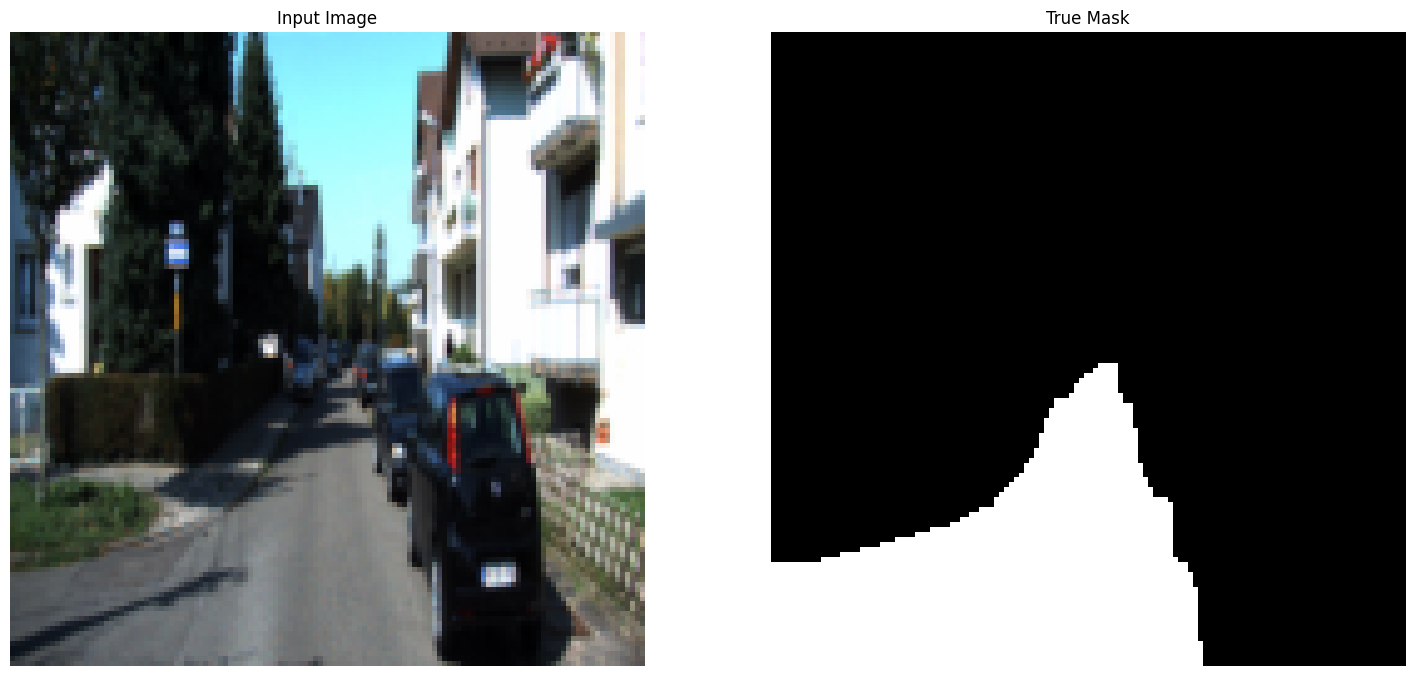

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image_np = display_list[i] #.cpu().numpy()  # Move to CPU if necessary
        # Handle different image shapes
        if image_np.shape[0] == 3:  # RGB (3, 128, 128)
            plt.imshow(image_np.permute(1,2, 0))
        elif image_np.shape[0] == 1:  # Grayscale (1, 128, 128)
            plt.imshow(image_np[0], cmap='gray')  # Squeeze the channel dimension
        else:
            raise ValueError(f"Unsupported image shape: {image_np.shape}")

        plt.axis('off')
    plt.show()

sample_image = train_dataset[1][0]
sample_mask = train_dataset[1][1]
print(sample_image.shape, sample_mask.shape, type(sample_image))
# Display the sample
display_sample([sample_image, sample_mask])

In [7]:
torch.nonzero(sample_mask), sample_mask[0, 126, 83]

(tensor([[  0,  67,  66],
         [  0,  67,  67],
         [  0,  67,  68],
         ...,
         [  0, 127,  84],
         [  0, 127,  85],
         [  0, 127,  86]]),
 tensor(1.))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


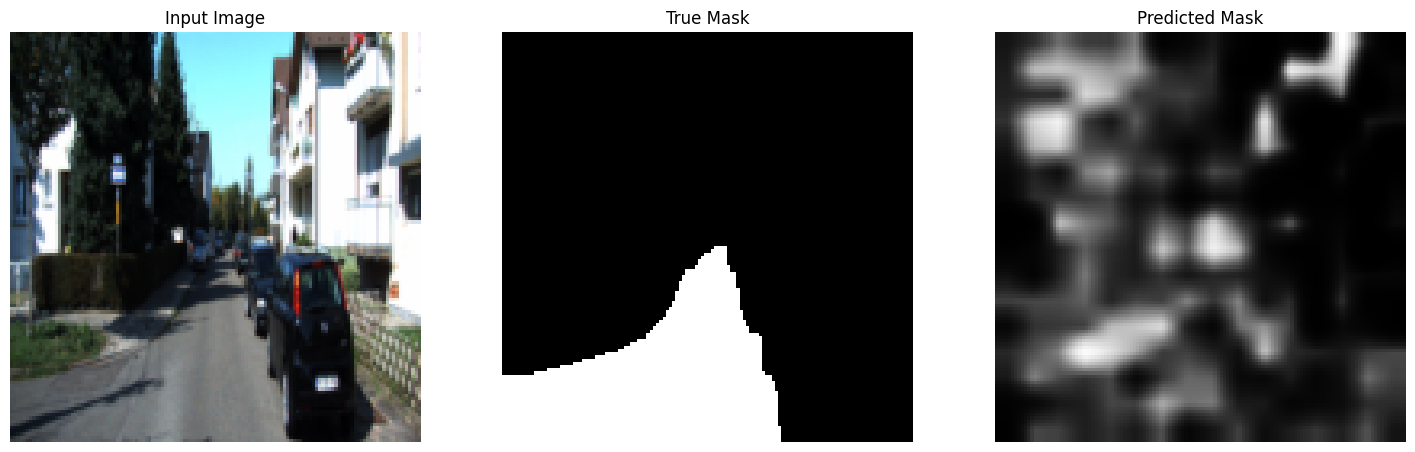

In [12]:
import torch
import torch.nn as nn
import torchvision

class VGG_FCN8(nn.Module):
    def __init__(self, n_classes):
        super(VGG_FCN8, self).__init__()
        self.n_classes = n_classes

        # Load the pre-trained VGG16 model without the classification layers
        vgg16 = torchvision.models.vgg16(pretrained=True)
        self.features = vgg16.features

        # Encoder layers
        self.c1 = None
        self.c2 = None
        self.c3 = None
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.up3 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)

        # conv2d layers
        self.downsampler = nn.Conv2d(512, 256, kernel_size=1)

        # Output layer
        self.output_conv = nn.Conv2d(256, n_classes, kernel_size=1)  # Adjust in_channels as needed
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:  # Adjust index to get output after block3_pool
                self.c1 = x
            elif i == 23:  # Adjust index to get output after block4_pool
                self.c2 = x
            elif i == 30:  # Adjust index to get output after block5_pool
                self.c3 = x

        # Decoder
        u1 = self.up1(self.c3)
        d1 = torch.add(u1, self.c2)
        # d1 = nn.Conv2d(d1.shape[1], 256, kernel_size=1)(d1)
        d1 = self.downsampler(d1)
        # d1 = nn.Sigmoid()(d1)

        u2 = self.up2(d1)
        d2 = torch.add(u2, self.c1)
        # d2 = nn.Conv2d(d2.shape[1], 256, kernel_size=1)(d2)
        # d2 = nn.Sigmoid()(d2)

        # Output
        u3 = self.up3(d2)
        outputs = self.output_conv(u3)
        outputs = self.sigmoid(outputs)

        return outputs

# Create the model
model = VGG_FCN8(n_classes=N_CLASSES)

# Input tensor
inputs = torch.randn(1, N_CHANNELS, IMG_SIZE, IMG_SIZE)  # Example input

# Get the output
outputs = model(inputs)
model.eval()
sample_pred = model(sample_image.unsqueeze(0)).detach()
x = sample_pred.squeeze(0).shape
display_sample([sample_image, sample_mask, sample_pred.squeeze(0)])

In [34]:
import torch
from tqdm import tqdm  # For progress bar
!pip install torchmetrics

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics import MeanMetric, JaccardIndex
# Training parameters
epochs = 200  # Number of training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

# Move model to device
model = model.to(device)

# Define optimizer optimizer = optim.Adam(effViT_model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Define loss function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Define metric
m_iou = JaccardIndex(task="binary").to(device)
iou_metric = MeanMetric().to(device)

def train_step(images, labels):
    model.train()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Calculate and accumulate IoU
    iou = m_iou(outputs, labels)
    iou_metric.update(iou)

    return loss.item(), iou.item()

def val_step(images, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate and accumulate IoU
        iou = m_iou(outputs, labels)
        iou_metric.update(iou)

    return loss.item(), iou.item()

# Training loop
for epoch in range(epochs):
    # Training phase
    train_loss = 0.0
    train_iou = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        images = images.to(device)
        labels = labels.to(device)
        loss, iou = train_step(images, labels)
        train_loss += loss
        train_iou += iou

    # Calculate average training loss and IoU
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # Validation phase
    val_loss = 0.0
    val_iou = 0.0
    for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
        images = images.to(device)
        labels = labels.to(device)
        loss, iou = val_step(images, labels)
        val_loss += loss
        val_iou += iou

    # Calculate average validation loss and IoU
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training IoU: {avg_train_iou:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation IoU: {avg_val_iou:.4f}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")  # Choose your desired file name

Epoch 1/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 1/100:
  Training Loss: 0.1783, Training IoU: 0.6971
  Validation Loss: 0.1662, Validation IoU: 0.7358


Epoch 2/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 2/100:
  Training Loss: 0.1456, Training IoU: 0.7327
  Validation Loss: 0.1211, Validation IoU: 0.7511


Epoch 3/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 3/100:
  Training Loss: 0.1250, Training IoU: 0.7630
  Validation Loss: 0.1179, Validation IoU: 0.7748


Epoch 4/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 4/100:
  Training Loss: 0.1229, Training IoU: 0.7607
  Validation Loss: 0.1093, Validation IoU: 0.7787


Epoch 5/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 5/100:
  Training Loss: 0.1185, Training IoU: 0.7734
  Validation Loss: 0.1115, Validation IoU: 0.7761


Epoch 6/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 6/100:
  Training Loss: 0.1175, Training IoU: 0.7719
  Validation Loss: 0.1099, Validation IoU: 0.7811


Epoch 7/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 7/100:
  Training Loss: 0.1169, Training IoU: 0.7736
  Validation Loss: 0.1105, Validation IoU: 0.7780


Epoch 8/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 8/100:
  Training Loss: 0.1165, Training IoU: 0.7754
  Validation Loss: 0.1091, Validation IoU: 0.7787


Epoch 9/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Epoch 9/100:
  Training Loss: 0.1159, Training IoU: 0.7758
  Validation Loss: 0.1093, Validation IoU: 0.7820


Epoch 10/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 10/100:
  Training Loss: 0.1156, Training IoU: 0.7769
  Validation Loss: 0.1091, Validation IoU: 0.7816


Epoch 11/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 11/100:
  Training Loss: 0.1155, Training IoU: 0.7775
  Validation Loss: 0.1087, Validation IoU: 0.7814


Epoch 12/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 12/100:
  Training Loss: 0.1151, Training IoU: 0.7781
  Validation Loss: 0.1085, Validation IoU: 0.7825


Epoch 13/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 13/100:
  Training Loss: 0.1149, Training IoU: 0.7783
  Validation Loss: 0.1082, Validation IoU: 0.7840


Epoch 14/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch 14/100:
  Training Loss: 0.1149, Training IoU: 0.7783
  Validation Loss: 0.1079, Validation IoU: 0.7854


Epoch 15/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 15/100:
  Training Loss: 0.1146, Training IoU: 0.7787
  Validation Loss: 0.1076, Validation IoU: 0.7863


Epoch 16/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Epoch 16/100:
  Training Loss: 0.1145, Training IoU: 0.7791
  Validation Loss: 0.1074, Validation IoU: 0.7870


Epoch 17/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Epoch 17/100:
  Training Loss: 0.1144, Training IoU: 0.7791
  Validation Loss: 0.1071, Validation IoU: 0.7879


Epoch 18/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 18/100:
  Training Loss: 0.1142, Training IoU: 0.7796
  Validation Loss: 0.1070, Validation IoU: 0.7893


Epoch 19/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 19/100:
  Training Loss: 0.1141, Training IoU: 0.7798
  Validation Loss: 0.1069, Validation IoU: 0.7907


Epoch 20/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch 20/100:
  Training Loss: 0.1140, Training IoU: 0.7800
  Validation Loss: 0.1067, Validation IoU: 0.7920


Epoch 21/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 21/100:
  Training Loss: 0.1139, Training IoU: 0.7803
  Validation Loss: 0.1068, Validation IoU: 0.7931


Epoch 22/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 22/100:
  Training Loss: 0.1138, Training IoU: 0.7804
  Validation Loss: 0.1068, Validation IoU: 0.7938


Epoch 23/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 23/100:
  Training Loss: 0.1138, Training IoU: 0.7806
  Validation Loss: 0.1067, Validation IoU: 0.7944


Epoch 24/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 24/100:
  Training Loss: 0.1137, Training IoU: 0.7807
  Validation Loss: 0.1066, Validation IoU: 0.7950


Epoch 25/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 25/100:
  Training Loss: 0.1136, Training IoU: 0.7809
  Validation Loss: 0.1063, Validation IoU: 0.7953


Epoch 26/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 26/100:
  Training Loss: 0.1136, Training IoU: 0.7807
  Validation Loss: 0.1060, Validation IoU: 0.7957


Epoch 27/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Epoch 27/100:
  Training Loss: 0.1133, Training IoU: 0.7812
  Validation Loss: 0.1055, Validation IoU: 0.7961


Epoch 28/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Epoch 28/100:
  Training Loss: 0.1131, Training IoU: 0.7816
  Validation Loss: 0.1050, Validation IoU: 0.7965


Epoch 29/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Epoch 29/100:
  Training Loss: 0.1127, Training IoU: 0.7823
  Validation Loss: 0.1049, Validation IoU: 0.7969


Epoch 30/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 30/100:
  Training Loss: 0.1123, Training IoU: 0.7833
  Validation Loss: 0.1047, Validation IoU: 0.7977


Epoch 31/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 31/100:
  Training Loss: 0.1120, Training IoU: 0.7842
  Validation Loss: 0.1047, Validation IoU: 0.7987


Epoch 32/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 32/100:
  Training Loss: 0.1118, Training IoU: 0.7847
  Validation Loss: 0.1047, Validation IoU: 0.7992


Epoch 33/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 33/100:
  Training Loss: 0.1115, Training IoU: 0.7853
  Validation Loss: 0.1049, Validation IoU: 0.7993


Epoch 34/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 34/100:
  Training Loss: 0.1114, Training IoU: 0.7856
  Validation Loss: 0.1048, Validation IoU: 0.7997


Epoch 35/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Epoch 35/100:
  Training Loss: 0.1111, Training IoU: 0.7860
  Validation Loss: 0.1049, Validation IoU: 0.8001


Epoch 36/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 36/100:
  Training Loss: 0.1110, Training IoU: 0.7864
  Validation Loss: 0.1049, Validation IoU: 0.8005


Epoch 37/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Epoch 37/100:
  Training Loss: 0.1109, Training IoU: 0.7866
  Validation Loss: 0.1048, Validation IoU: 0.8007


Epoch 38/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Epoch 38/100:
  Training Loss: 0.1106, Training IoU: 0.7870
  Validation Loss: 0.1043, Validation IoU: 0.8013


Epoch 39/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Epoch 39/100:
  Training Loss: 0.1103, Training IoU: 0.7875
  Validation Loss: 0.1043, Validation IoU: 0.8016


Epoch 40/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Epoch 40/100:
  Training Loss: 0.1102, Training IoU: 0.7876
  Validation Loss: 0.1038, Validation IoU: 0.8021


Epoch 41/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 41/100:
  Training Loss: 0.1099, Training IoU: 0.7880
  Validation Loss: 0.1033, Validation IoU: 0.8025


Epoch 42/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 42/100:
  Training Loss: 0.1096, Training IoU: 0.7885
  Validation Loss: 0.1029, Validation IoU: 0.8032


Epoch 43/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 43/100:
  Training Loss: 0.1093, Training IoU: 0.7894
  Validation Loss: 0.1024, Validation IoU: 0.8040


Epoch 44/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 44/100:
  Training Loss: 0.1090, Training IoU: 0.7900
  Validation Loss: 0.1018, Validation IoU: 0.8046


Epoch 45/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 45/100:
  Training Loss: 0.1087, Training IoU: 0.7905
  Validation Loss: 0.1008, Validation IoU: 0.8054


Epoch 46/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Epoch 46/100:
  Training Loss: 0.1080, Training IoU: 0.7920
  Validation Loss: 0.1003, Validation IoU: 0.8056


Epoch 47/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Epoch 47/100:
  Training Loss: 0.1074, Training IoU: 0.7931
  Validation Loss: 0.0999, Validation IoU: 0.8063


Epoch 48/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Epoch 48/100:
  Training Loss: 0.1067, Training IoU: 0.7947
  Validation Loss: 0.0994, Validation IoU: 0.8076


Epoch 49/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 49/100:
  Training Loss: 0.1059, Training IoU: 0.7967
  Validation Loss: 0.0997, Validation IoU: 0.8083


Epoch 50/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 50/100:
  Training Loss: 0.1054, Training IoU: 0.7980
  Validation Loss: 0.0999, Validation IoU: 0.8088


Epoch 51/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 51/100:
  Training Loss: 0.1047, Training IoU: 0.8001
  Validation Loss: 0.1000, Validation IoU: 0.8091


Epoch 52/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 52/100:
  Training Loss: 0.1043, Training IoU: 0.8012
  Validation Loss: 0.0992, Validation IoU: 0.8104


Epoch 53/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 53/100:
  Training Loss: 0.1037, Training IoU: 0.8023
  Validation Loss: 0.0979, Validation IoU: 0.8120


Epoch 54/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Epoch 54/100:
  Training Loss: 0.1028, Training IoU: 0.8041
  Validation Loss: 0.0970, Validation IoU: 0.8135


Epoch 55/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 55/100:
  Training Loss: 0.1019, Training IoU: 0.8059
  Validation Loss: 0.0960, Validation IoU: 0.8149


Epoch 56/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Epoch 56/100:
  Training Loss: 0.1010, Training IoU: 0.8079
  Validation Loss: 0.0951, Validation IoU: 0.8169


Epoch 57/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 57/100:
  Training Loss: 0.1002, Training IoU: 0.8097
  Validation Loss: 0.0939, Validation IoU: 0.8185


Epoch 58/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 58/100:
  Training Loss: 0.0992, Training IoU: 0.8118
  Validation Loss: 0.0935, Validation IoU: 0.8198


Epoch 59/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 59/100:
  Training Loss: 0.0987, Training IoU: 0.8131
  Validation Loss: 0.0931, Validation IoU: 0.8211


Epoch 60/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 60/100:
  Training Loss: 0.0981, Training IoU: 0.8146
  Validation Loss: 0.0927, Validation IoU: 0.8224


Epoch 61/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 61/100:
  Training Loss: 0.0975, Training IoU: 0.8164
  Validation Loss: 0.0928, Validation IoU: 0.8237


Epoch 62/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 62/100:
  Training Loss: 0.0971, Training IoU: 0.8171
  Validation Loss: 0.0925, Validation IoU: 0.8237


Epoch 63/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Epoch 63/100:
  Training Loss: 0.0968, Training IoU: 0.8182
  Validation Loss: 0.0923, Validation IoU: 0.8250


Epoch 64/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch 64/100:
  Training Loss: 0.0965, Training IoU: 0.8188
  Validation Loss: 0.0918, Validation IoU: 0.8265


Epoch 65/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch 65/100:
  Training Loss: 0.0965, Training IoU: 0.8187
  Validation Loss: 0.0911, Validation IoU: 0.8271


Epoch 66/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 66/100:
  Training Loss: 0.0963, Training IoU: 0.8189
  Validation Loss: 0.0913, Validation IoU: 0.8254


Epoch 67/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 67/100:
  Training Loss: 0.0962, Training IoU: 0.8181
  Validation Loss: 0.0931, Validation IoU: 0.8228


Epoch 68/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 68/100:
  Training Loss: 0.0959, Training IoU: 0.8184
  Validation Loss: 0.0921, Validation IoU: 0.8257


Epoch 69/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 69/100:
  Training Loss: 0.0951, Training IoU: 0.8203
  Validation Loss: 0.0897, Validation IoU: 0.8301


Epoch 70/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 70/100:
  Training Loss: 0.0936, Training IoU: 0.8241
  Validation Loss: 0.0902, Validation IoU: 0.8269


Epoch 71/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Epoch 71/100:
  Training Loss: 0.0923, Training IoU: 0.8277
  Validation Loss: 0.0901, Validation IoU: 0.8271


Epoch 72/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Epoch 72/100:
  Training Loss: 0.0925, Training IoU: 0.8286
  Validation Loss: 0.0915, Validation IoU: 0.8249


Epoch 73/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 73/100:
  Training Loss: 0.0931, Training IoU: 0.8251
  Validation Loss: 0.0921, Validation IoU: 0.8284


Epoch 74/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch 74/100:
  Training Loss: 0.0929, Training IoU: 0.8250
  Validation Loss: 0.0925, Validation IoU: 0.8285


Epoch 75/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Epoch 75/100:
  Training Loss: 0.0927, Training IoU: 0.8251
  Validation Loss: 0.0892, Validation IoU: 0.8336


Epoch 76/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 76/100:
  Training Loss: 0.0938, Training IoU: 0.8238
  Validation Loss: 0.0919, Validation IoU: 0.8201


Epoch 77/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 77/100:
  Training Loss: 0.0922, Training IoU: 0.8268
  Validation Loss: 0.0908, Validation IoU: 0.8280


Epoch 78/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 78/100:
  Training Loss: 0.0907, Training IoU: 0.8310
  Validation Loss: 0.0893, Validation IoU: 0.8323


Epoch 79/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 79/100:
  Training Loss: 0.0903, Training IoU: 0.8323
  Validation Loss: 0.0881, Validation IoU: 0.8338


Epoch 80/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 80/100:
  Training Loss: 0.0891, Training IoU: 0.8340
  Validation Loss: 0.0880, Validation IoU: 0.8354


Epoch 81/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 81/100:
  Training Loss: 0.0889, Training IoU: 0.8346
  Validation Loss: 0.0884, Validation IoU: 0.8344


Epoch 82/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 82/100:
  Training Loss: 0.0902, Training IoU: 0.8317
  Validation Loss: 0.0892, Validation IoU: 0.8265


Epoch 83/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Epoch 83/100:
  Training Loss: 0.0902, Training IoU: 0.8313
  Validation Loss: 0.0896, Validation IoU: 0.8266


Epoch 84/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch 84/100:
  Training Loss: 0.0888, Training IoU: 0.8345
  Validation Loss: 0.0907, Validation IoU: 0.8300


Epoch 85/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Epoch 85/100:
  Training Loss: 0.0884, Training IoU: 0.8353
  Validation Loss: 0.0884, Validation IoU: 0.8346


Epoch 86/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 86/100:
  Training Loss: 0.0877, Training IoU: 0.8363
  Validation Loss: 0.0882, Validation IoU: 0.8366


Epoch 87/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch 87/100:
  Training Loss: 0.0872, Training IoU: 0.8375
  Validation Loss: 0.0889, Validation IoU: 0.8348


Epoch 88/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 88/100:
  Training Loss: 0.0879, Training IoU: 0.8360
  Validation Loss: 0.0874, Validation IoU: 0.8344


Epoch 89/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 89/100:
  Training Loss: 0.0886, Training IoU: 0.8348
  Validation Loss: 0.0916, Validation IoU: 0.8157


Epoch 90/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 90/100:
  Training Loss: 0.0881, Training IoU: 0.8353
  Validation Loss: 0.0896, Validation IoU: 0.8326


Epoch 91/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 91/100:
  Training Loss: 0.0871, Training IoU: 0.8401
  Validation Loss: 0.0885, Validation IoU: 0.8310


Epoch 92/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 92/100:
  Training Loss: 0.0868, Training IoU: 0.8388
  Validation Loss: 0.0877, Validation IoU: 0.8328


Epoch 93/100 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 93/100:
  Training Loss: 0.0849, Training IoU: 0.8432
  Validation Loss: 0.0873, Validation IoU: 0.8359


Epoch 94/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Epoch 94/100:
  Training Loss: 0.0845, Training IoU: 0.8444
  Validation Loss: 0.0868, Validation IoU: 0.8337


Epoch 95/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 95/100:
  Training Loss: 0.0849, Training IoU: 0.8432
  Validation Loss: 0.0868, Validation IoU: 0.8373


Epoch 96/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Epoch 96/100:
  Training Loss: 0.0846, Training IoU: 0.8445
  Validation Loss: 0.0886, Validation IoU: 0.8354


Epoch 97/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 97/100:
  Training Loss: 0.0855, Training IoU: 0.8407
  Validation Loss: 0.0904, Validation IoU: 0.8330


Epoch 98/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch 98/100:
  Training Loss: 0.0862, Training IoU: 0.8385
  Validation Loss: 0.0863, Validation IoU: 0.8366


Epoch 99/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch 99/100:
  Training Loss: 0.0853, Training IoU: 0.8408
  Validation Loss: 0.0917, Validation IoU: 0.8157


Epoch 100/100 - Validation: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

Epoch 100/100:
  Training Loss: 0.0857, Training IoU: 0.8412
  Validation Loss: 0.0874, Validation IoU: 0.8391


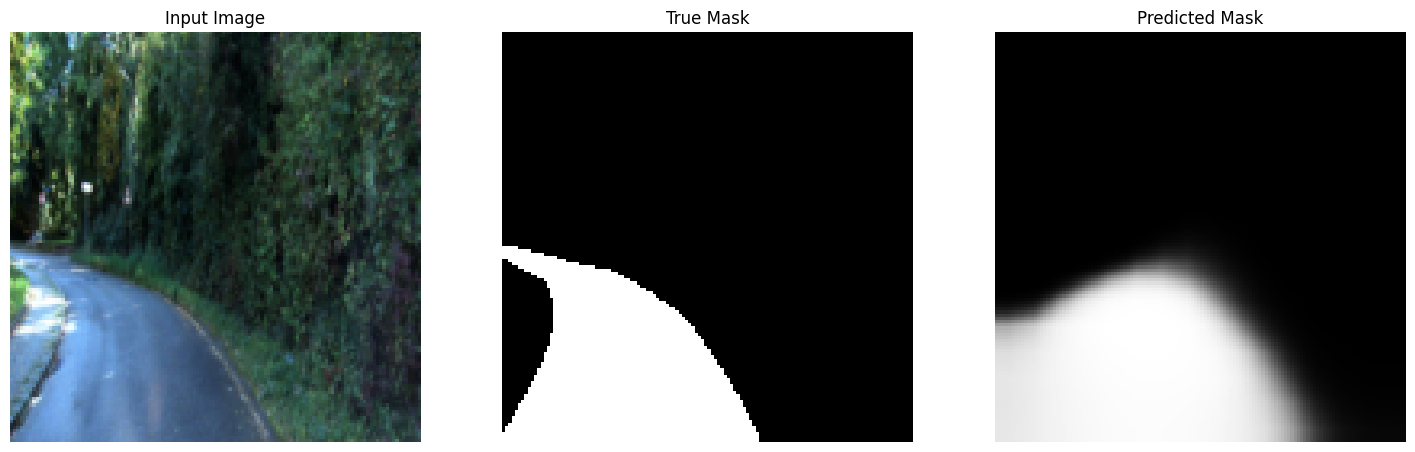

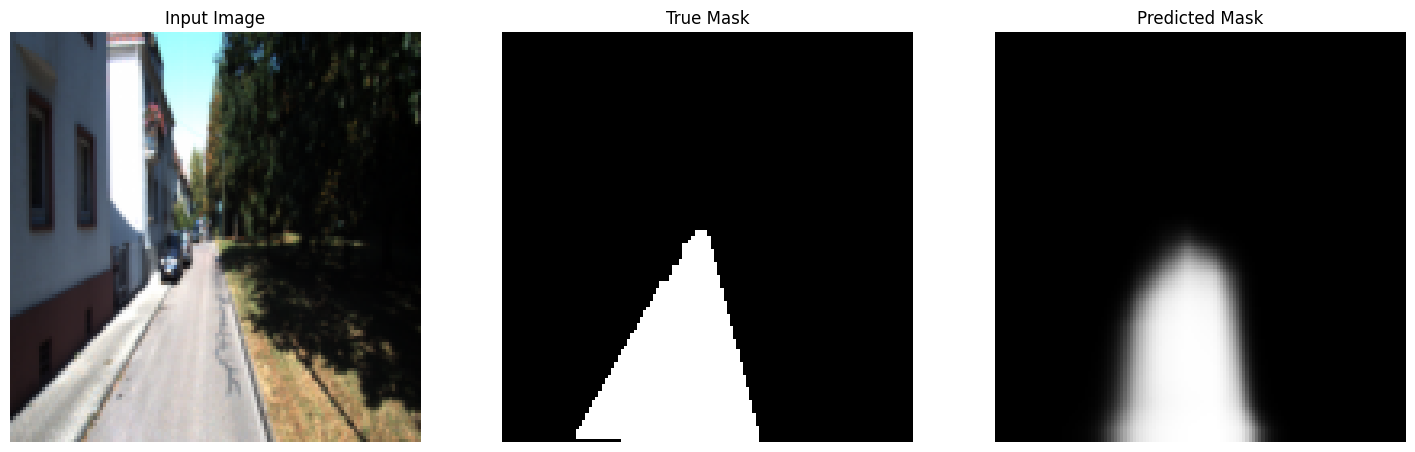

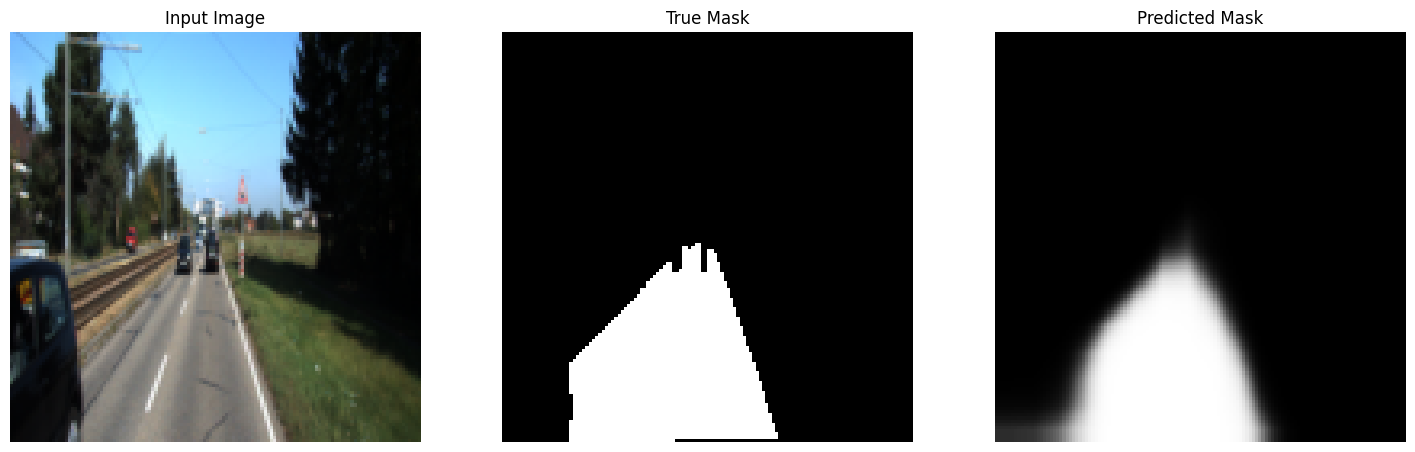

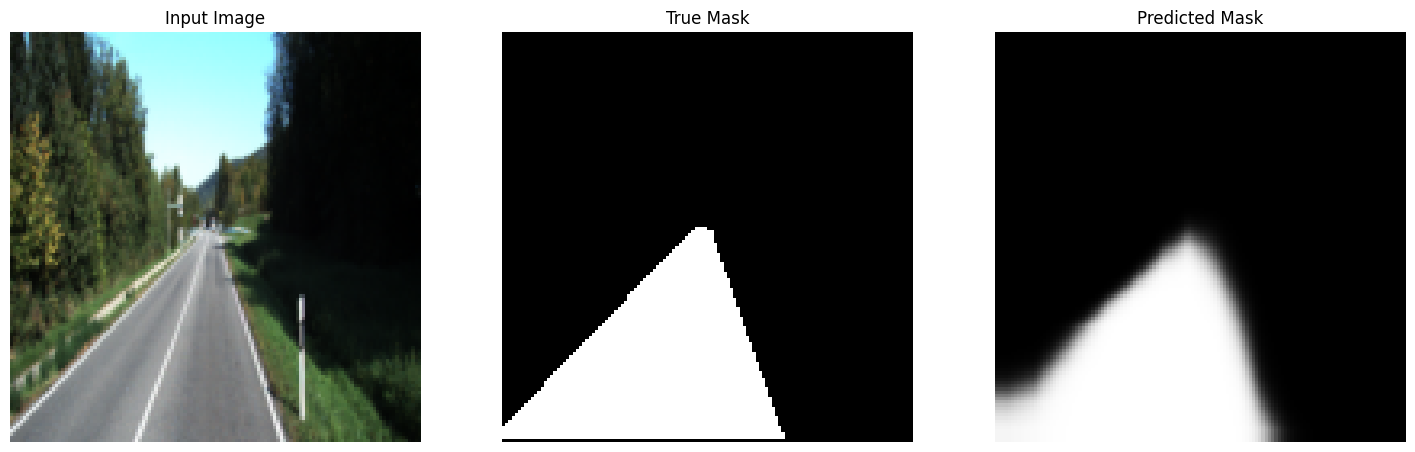

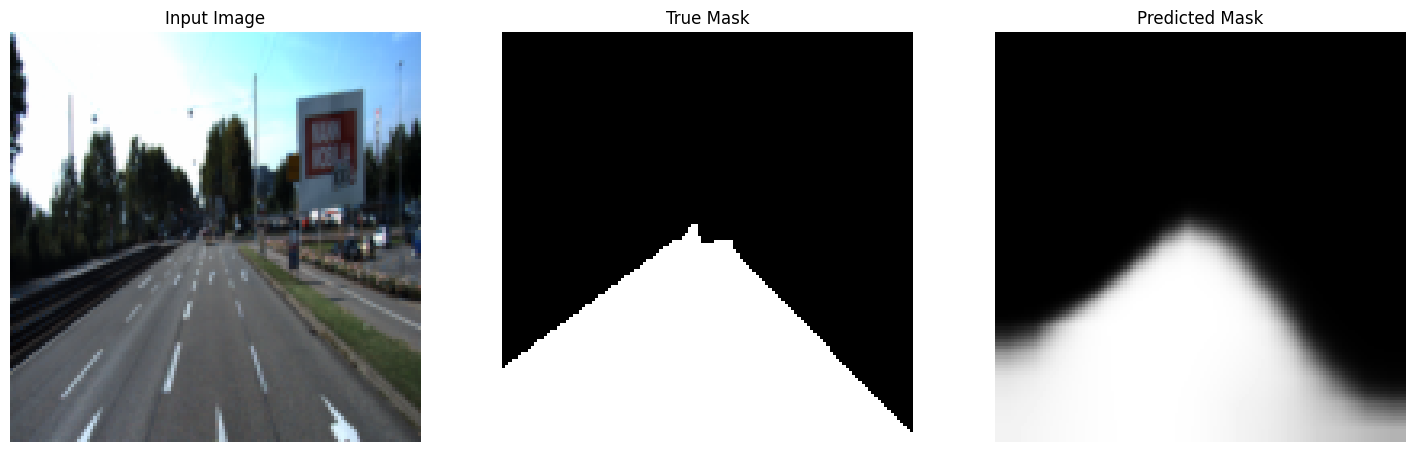

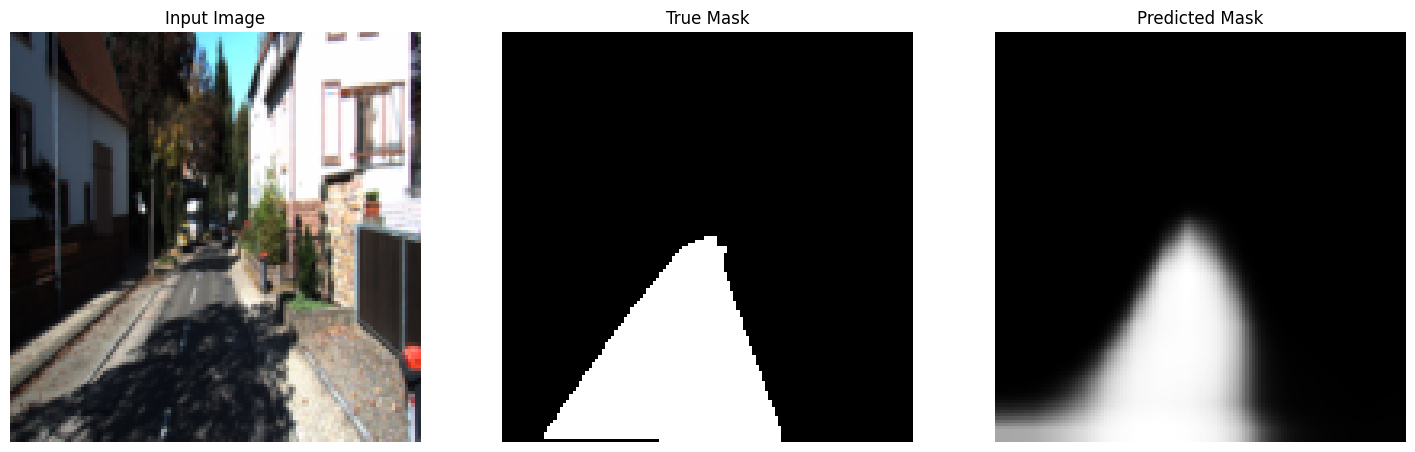

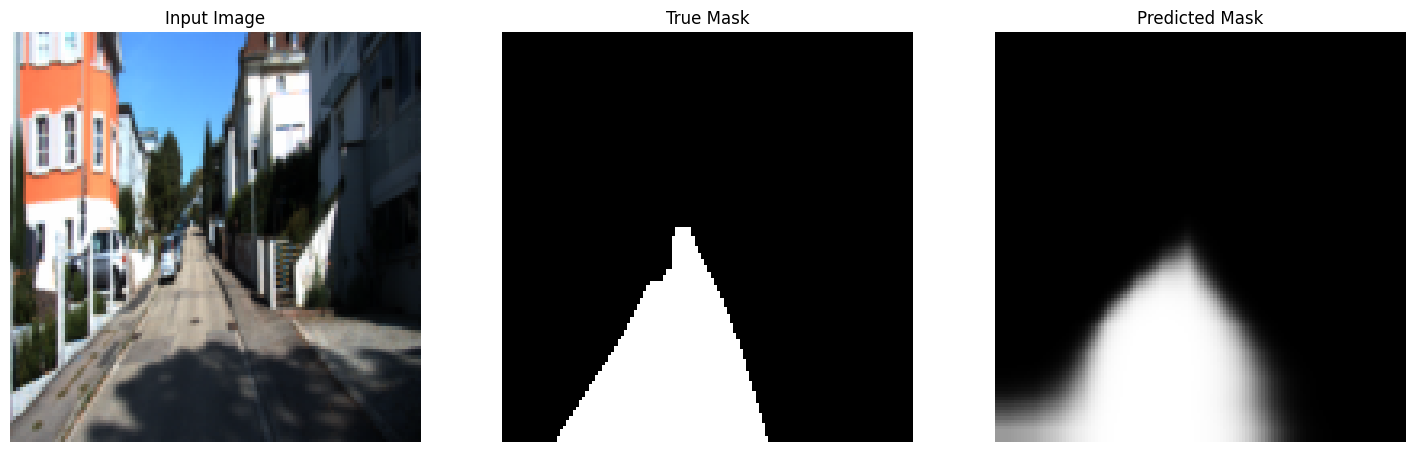

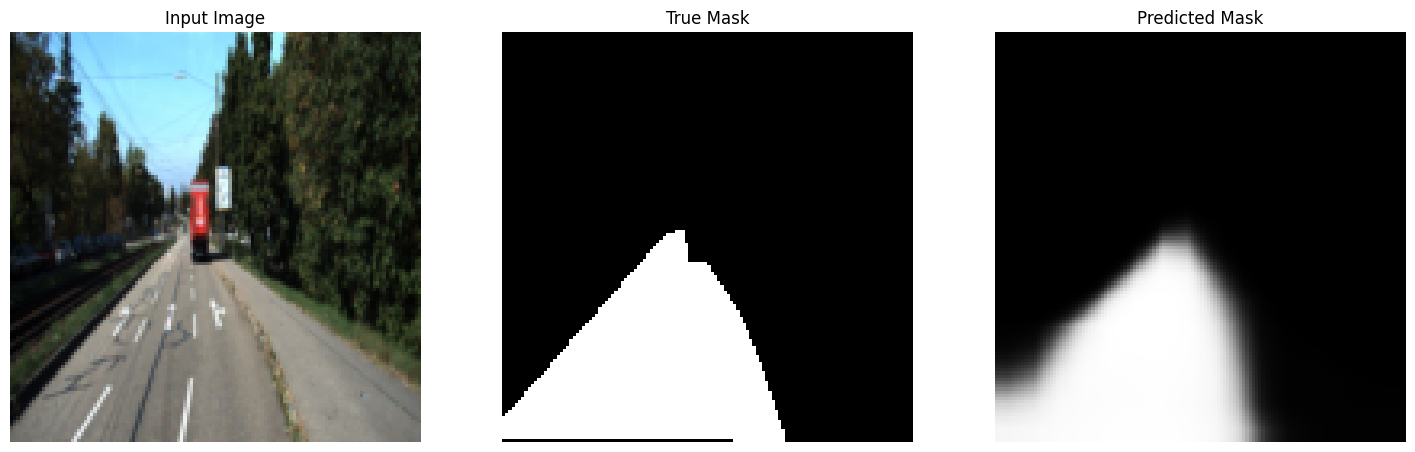

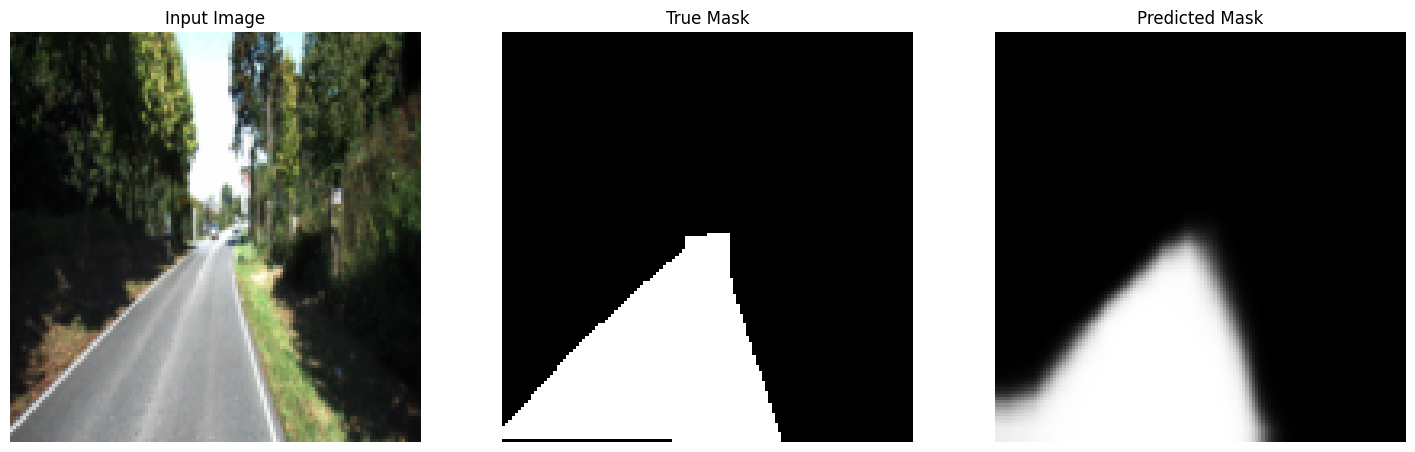

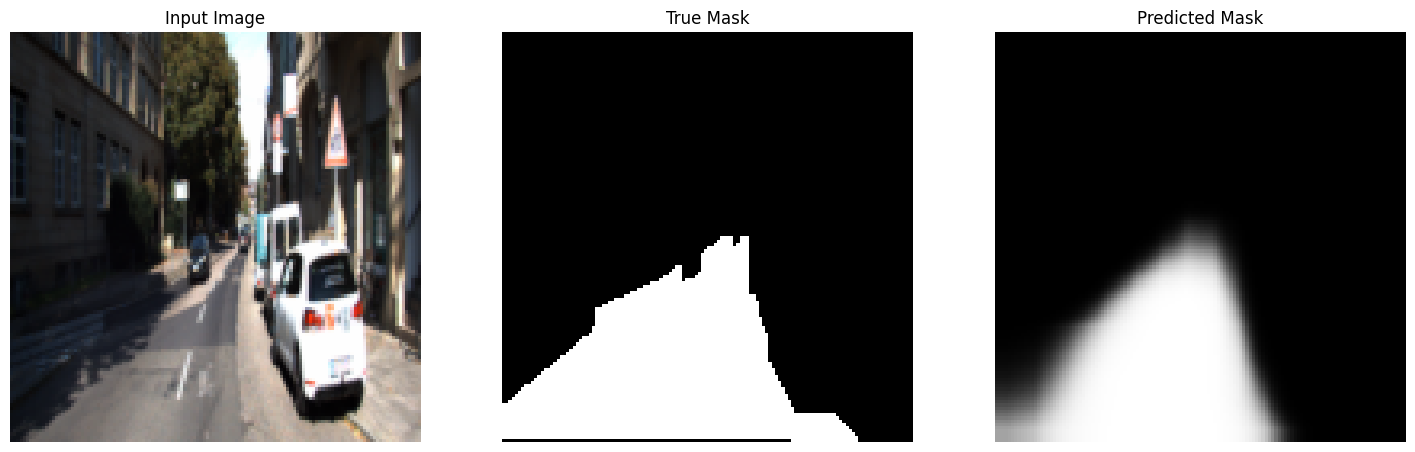

In [50]:
for i in range(10,20):
  sample_image = test_dataset[i][0]
  sample_mask = test_dataset[i][1]
  model.eval()
  sample_pred = model(sample_image.unsqueeze(0).to(device))
  x = torch.where(sample_pred.squeeze(0).detach().to('cpu') > 0.8, torch.tensor(1.0), torch.tensor(0.0))
  display_sample([sample_image, sample_mask, sample_pred.squeeze(0).detach().to('cpu')])